In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Configuration
csv_file_path = './data/newTestingData.csv' # Ensure this file is in your notebook's directory
BATCH_SIZE = 64
EPOCHS = 20
EMBEDDING_DIM = 64 # Size of the vector space for parts
LSTM_UNITS = 100   # Number of memory units in the LSTM

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


In [2]:
# Load data
df = pd.read_csv(csv_file_path)

# Keep only necessary columns
df = df[['CUST_ORDER_ID', 'PART_ID', 'LOCATION_RANK']]

# Drop rows with missing critical values
df.dropna(subset=['PART_ID', 'LOCATION_RANK'], inplace=True)

# Sort by Order ID and then by Rank to ensure the sequence is chronological
df = df.sort_values(by=['CUST_ORDER_ID', 'LOCATION_RANK'])

# Convert PART_ID to string so it is treated as a categorical label, not a number
df['PART_ID'] = df['PART_ID'].astype(str)

print(f"Data Loaded: {len(df)} rows.")
print("Sample of sorted data:")
display(df.head(10))

Data Loaded: 4205 rows.
Sample of sorted data:


,CUST_ORDER_ID,PART_ID,LOCATION_RANK
1615,008247-1,1096161009,1
64,008485,1517022201,1
1106,008878,1912061001,1
295,010316-1,1050105057,1
1608,011399,1411081001,1
1609,011399,1511051001,2
1610,011399,1411071001,3
1611,011399,1412051001,4
1612,011399,1417052001,5
1119,011806-1,1912061001,1


In [3]:
# 1. Label Encode Part IDs (Convert string IDs to integers 0, 1, 2...)
label_encoder = LabelEncoder()
df['PART_ID_ENCODED'] = label_encoder.fit_transform(df['PART_ID'])

# Calculate vocabulary size (Total unique parts) + 1 for padding
vocab_size = len(label_encoder.classes_) + 1
print(f"Unique Parts (Vocabulary Size): {vocab_size}")

# 2. Group by Order to get sequences
# This creates a list of lists, where each inner list is an order sequence
order_sequences = df.groupby('CUST_ORDER_ID')['PART_ID_ENCODED'].apply(list).values

# 3. Create N-gram sequences for training
input_sequences = []
for sequence in order_sequences:
    # We need at least 2 parts to predict the next one
    if len(sequence) > 1:
        for i in range(1, len(sequence)):
            # Take the first i+1 parts (e.g., [Part1, Part2])
            n_gram_sequence = sequence[:i+1]
            input_sequences.append(n_gram_sequence)

# 4. Pad sequences
# Determine the maximum length of any sequence in the data
max_sequence_len = max([len(x) for x in input_sequences])
print(f"Max Sequence Length: {max_sequence_len}")

# Pad sequences with 0s at the beginning so they are all the same length
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# 5. Split into Features (X) and Target (y)
# X is everything except the last item, y is the last item
X, y = input_sequences[:, :-1], input_sequences[:, -1]

print(f"Total Training Sequences Generated: {len(X)}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Unique Parts (Vocabulary Size): 337
Max Sequence Length: 32
Total Training Sequences Generated: 3428
Shape of X: (3428, 31)
Shape of y: (3428,)


In [5]:
model = Sequential()

# Embedding Layer: Turns integer Part IDs into dense vectors
# input_length is max_sequence_len - 1 because we removed the label column
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=EMBEDDING_DIM))

# LSTM Layer
model.add(LSTM(LSTM_UNITS))
model.add(Dropout(0.2)) # Randomly drop neurons to prevent overfitting

# Output Layer
# Softmax gives us a probability distribution over all possible parts
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.0333 - loss: 5.3144
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0338 - loss: 4.9772
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0382 - loss: 4.9266
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0443 - loss: 4.8599
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0551 - loss: 4.7801
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0540 - loss: 4.7138
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0642 - loss: 4.6439
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0764 - loss: 4.5837
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0779 - loss: 4.5233
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0858 - loss: 4.4759
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0904 - loss: 4.4214
Epoch 12/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy:

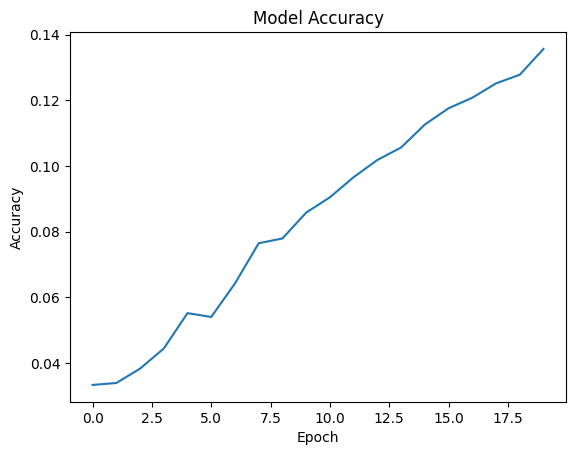

In [6]:
history = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# Plot Training Accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [7]:
def predict_next_part(model, tokenizer, current_sequence):
    """
    Predicts the next part based on the current sequence of parts.
    """
    # 1. Encode the input sequence using the same label encoder as training
    encoded_seq = []
    for part in current_sequence:
        try:
            # Transform string part ID to integer
            encoded_id = tokenizer.transform([str(part)])[0]
            encoded_seq.append(encoded_id)
        except ValueError:
            # Skip parts that were never seen during training
            print(f"Warning: Part '{part}' not found in training data.")
            continue
            
    if not encoded_seq:
        return "Unknown Sequence"

    # 2. Pad the sequence to match the model's expected input length
    padded_seq = pad_sequences([encoded_seq], maxlen=max_sequence_len-1, padding='pre')
    
    # 3. Get predictions (probabilities)
    predictions = model.predict(padded_seq, verbose=0)
    
    # 4. Get the index of the highest probability
    predicted_index = np.argmax(predictions, axis=-1)[0]
    
    # 5. Convert integer back to Part ID string
    predicted_part = tokenizer.inverse_transform([predicted_index])[0]
    
    return predicted_part

print("Prediction function ready.")

Prediction function ready.


In [21]:
# --- Pick a random order to test ---
import random

# Get a random order ID from the data
random_order_id = random.choice(df['CUST_ORDER_ID'].unique())
print(f"Testing Order ID: {random_order_id}")

# Get the actual sequence for this order
actual_sequence_df = df[df['CUST_ORDER_ID'] == random_order_id].sort_values('LOCATION_RANK')
actual_sequence = actual_sequence_df['PART_ID'].tolist()

if len(actual_sequence) < 2:
    print("Order too short to test prediction (needs at least 2 items).")
else:
    # Use all parts except the last one as input
    input_parts = actual_sequence[:-1]
    
    # The actual next part (Ground Truth)
    correct_next_part = actual_sequence[-1]
    
    print(f"Input Sequence: {input_parts}")
    print(f"Actual Next Part: {correct_next_part}")
    
    # Ask Model
    prediction = predict_next_part(model, label_encoder, input_parts)
    print(f"Model Predicted:  {prediction}")
    
    if prediction == correct_next_part:
        print("✅ SUCCESS! The model predicted correctly.")
    else:
        print("❌ INCORRECT. Prediction mismatch.")

Testing Order ID: 032277
Input Sequence: ['1083322001', '1083312001', '1030006001', '1310373001', '1310373009']
Actual Next Part: 1097062009
Model Predicted:  1097062009
✅ SUCCESS! The model predicted correctly.
